In [ ]:
# Install TensorFlow if not already installed (uncomment if needed)
# This cell sets up the environment by installing TensorFlow and importing all necessary libraries
# for building, training, and evaluating a neural network model.
!pip install tensorflow

# Core TensorFlow library
import tensorflow as tf
# Pandas for data manipulation and analysis
import pandas as pd
# Keras sequential model API
from tensorflow.keras import Sequential
# Keras layers for building the neural network
from tensorflow.keras.layers import Normalization, Dense, InputLayer
# Keras functional API for model creation
from tensorflow.keras import Input
# Keras Model class for functional API
from tensorflow.keras.models import Model
# Metric for evaluating regression models
from tensorflow.keras.metrics import RootMeanSquaredError
# Optimizer for training the neural network
from tensorflow.keras.optimizers import Adam
# Matplotlib for plotting and visualization
import matplotlib.pyplot as plt
# NumPy for numerical operations
import numpy as np
# Function to load a saved Keras model
from tensorflow.keras.models import load_model

In [ ]:
# Load the dataset from 'dataset.csv' into a pandas DataFrame
dataset_csv = pd.read_csv("dataset.csv", delimiter=",")
# Display the first few rows of the loaded dataset
dataset_csv

,age,gender,spo2,bpm,temp,sbp,dbp
0,37,0,95.702046,60,36.861707,124,86
1,77,1,96.689413,63,36.511633,126,84
2,68,0,98.508265,63,37.052049,131,78
3,41,0,95.011801,99,36.654747,118,72
4,25,0,98.623792,69,36.975098,138,76
...,...,...,...,...,...,...,...
200015,75,1,95.357470,87,37.058905,120,84
200016,76,1,99.340786,76,36.463631,131,89
200017,18,0,98.120530,81,36.665477,124,89
200018,66,0,95.362426,83,37.019873,125,86


In [ ]:
# Convert the pandas DataFrame to a TensorFlow constant and shuffle it
dataset_tf = tf.constant(dataset_csv)
dataset_tf = tf.random.shuffle(dataset_tf)

# Separate features (X) and labels (Y)
# X includes 'age', 'gender', 'spo2', 'bpm', 'temp'
# Y includes 'sbp', 'dbp'
X = dataset_tf[:, 0:5]
Y = dataset_tf[:, 5:]

# Define the total number of samples
N = dataset_tf.shape[0]

# Define the ratios for training, validation, and testing datasets
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# Split the dataset into training, validation, and testing sets
X_train = X[:int(N*TRAIN_RATIO), :]
Y_train = Y[:int(N*TRAIN_RATIO), :]
X_val = X[int(N*TRAIN_RATIO):int(N*(TRAIN_RATIO+VAL_RATIO)), :]
Y_val = Y[int(N*TRAIN_RATIO):int(N*(TRAIN_RATIO+VAL_RATIO)), :]
X_test = X[int(N*(TRAIN_RATIO+VAL_RATIO)):, :]
Y_test = Y[int(N*(TRAIN_RATIO+VAL_RATIO)):, :]

# Create TensorFlow datasets for training, validation, and testing
# Use shuffle with a larger buffer size for better randomization
# Batch the datasets and prefetch for optimized performance
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=N).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.shuffle(buffer_size=N).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(buffer_size=N).batch(32).prefetch(tf.data.AUTOTUNE)

# Print the shapes of the split datasets for verification
print(X_train)
print(Y_train)
print(X_val)
print(Y_val)
print(X_test)
print(Y_test)

tf.Tensor(
[[49.          0.         96.38854088 60.         37.18740341]
 [20.          0.         95.01649599 80.         36.92634001]
 [42.          0.         96.32399284 86.         36.48293986]
 ...
 [83.          1.         95.49267851 90.         36.06983116]
 [19.          1.         95.25375571 68.         37.36552867]
 [47.          0.         98.72067605 71.         36.64796452]], shape=(120012, 5), dtype=float64)
tf.Tensor(
[[131.  84.]
 [132.  80.]
 [132.  75.]
 ...
 [119.  73.]
 [114.  88.]
 [115.  85.]], shape=(120012, 2), dtype=float64)
tf.Tensor(
[[37.          1.         95.99215143 66.         36.61365023]
 [50.          1.         99.18077804 96.         36.96347701]
 [82.          1.         99.5009006  90.         37.08866965]
 ...
 [69.          0.         98.72763071 98.         37.31797986]
 [18.          0.         96.83673517 79.         36.76778201]
 [22.          1.         99.31742885 97.         36.04141329]], shape=(40004, 5), dtype=float64)
tf.Tensor(


In [ ]:
# Initialize the Normalization layer
normalizer = Normalization()
# Adapt the normalizer to the training data to learn its mean and variance
normalizer.adapt(X_train)

In [ ]:
# Define the input layer with 5 features
input = Input(shape = (5,))
# Define the Normalization layer (Note: The `normalizer` variable was already adapted in a previous cell, so it should be used directly here if normalization is intended as part of the model)
# For now, this line will create a new Normalization layer instance, which will not have been adapted.
# If the adapted 'normalizer' from cell vm5DO98w9oeq is to be used, it should be passed here.
normalizer_layer = Normalization()
normalizer_layer.adapt(X_train) # Adapt the new normalizer to the training data
x = normalizer_layer(input) # Apply normalization as the first step in the model

# Add hidden dense layers with ReLU activation
x = Dense(20, name = 'dense1', activation='relu')(x)
x = Dense(40, name = 'dense2', activation='relu')(x)
x = Dense(20, name = 'dense3', activation='relu')(x)

# Output layer with 2 units (for sbp and dbp) and linear activation (default for regression)
output = Dense(2)(x)

# Create the Keras model using the Functional API
model = Model(inputs = input ,outputs = output)

# Compile the model with Mean Squared Error (mse) loss, Adam optimizer, and Root Mean Squared Error (rmse) metric
model.compile(loss = 'mse', optimizer = 'adam', metrics=[RootMeanSquaredError()])

# Print a summary of the model architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,833 (7.16 KB)

 Trainable params: 1,822 (7.12 KB)

 Non-trainable params: 11 (48.00 B)

In [ ]:
# Train the model using the training dataset, validating with the validation dataset
# The model will be trained for 200 epochs, and training progress will be shown verbosely.
model.fit(train_dataset, validation_data=val_dataset, epochs=200, verbose=1)

Epoch 1/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1662.0706 - root_mean_squared_error: 36.0182 - val_loss: 55.6908 - val_root_mean_squared_error: 7.4626
Epoch 2/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 55.6291 - root_mean_squared_error: 7.4585 - val_loss: 54.5320 - val_root_mean_squared_error: 7.3846
Epoch 3/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 55.0740 - root_mean_squared_error: 7.4211 - val_loss: 54.9502 - val_root_mean_squared_error: 7.4128
Epoch 4/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 54.9689 - root_mean_squared_error: 7.4141 - val_loss: 55.5969 - val_root_mean_squared_error: 7.4563
Epoch 5/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 54.9863 - root_mean_squared_error: 7.4152 - val_loss: 55.4741 - val_root_mean_squared_error: 7.4481
Epoch 6/200
3751/3751 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 55.0339 - root_mean_squared_error: 7.4185 - val_loss: 54.4799 - val_root_mean_squared_error: 7.3810
Epoch 7/200
3751/37

In [ ]:
model.save("model1.keras")


In [ ]:
model.evaluate(X_test, Y_test, batch_size=32)

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 55.1761 - root_mean_squared_error: 7.4280


[55.188114166259766, 7.42887020111084]

In [ ]:
input = Input(shape = (5,))
normalizer = Normalization()
# norm = tf.keras.layers.preprocessing.Normalization()
normalizer.adapt(X_train)
x = normalizer(input)
x = Dense(50, name = 'dense1', activation="relu")(x)
x = Dense(50, name = 'dense2', activation="relu")(x)
x = Dense(20, name = 'dense3', activation="relu")(x)
output = Dense(2, activation="relu")(x)
model = Model(inputs = input ,outputs = output)
model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,923 (15.33 KB)

 Trainable params: 3,912 (15.28 KB)

 Non-trainable params: 11 (48.00 B)

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 558.4937 - root_mean_squared_error: 20.4865 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 78.2362 - root_mean_squared_error: 8.8385 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 60.2361 - root_mean_squared_error: 7.7598 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 61.1936 - root_mean_squared_error: 7.8156 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 60.8469 - root_mean_squared_error: 7.7952 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 59.6748 - root_mean_squared_error: 7.7227 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 57.972

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


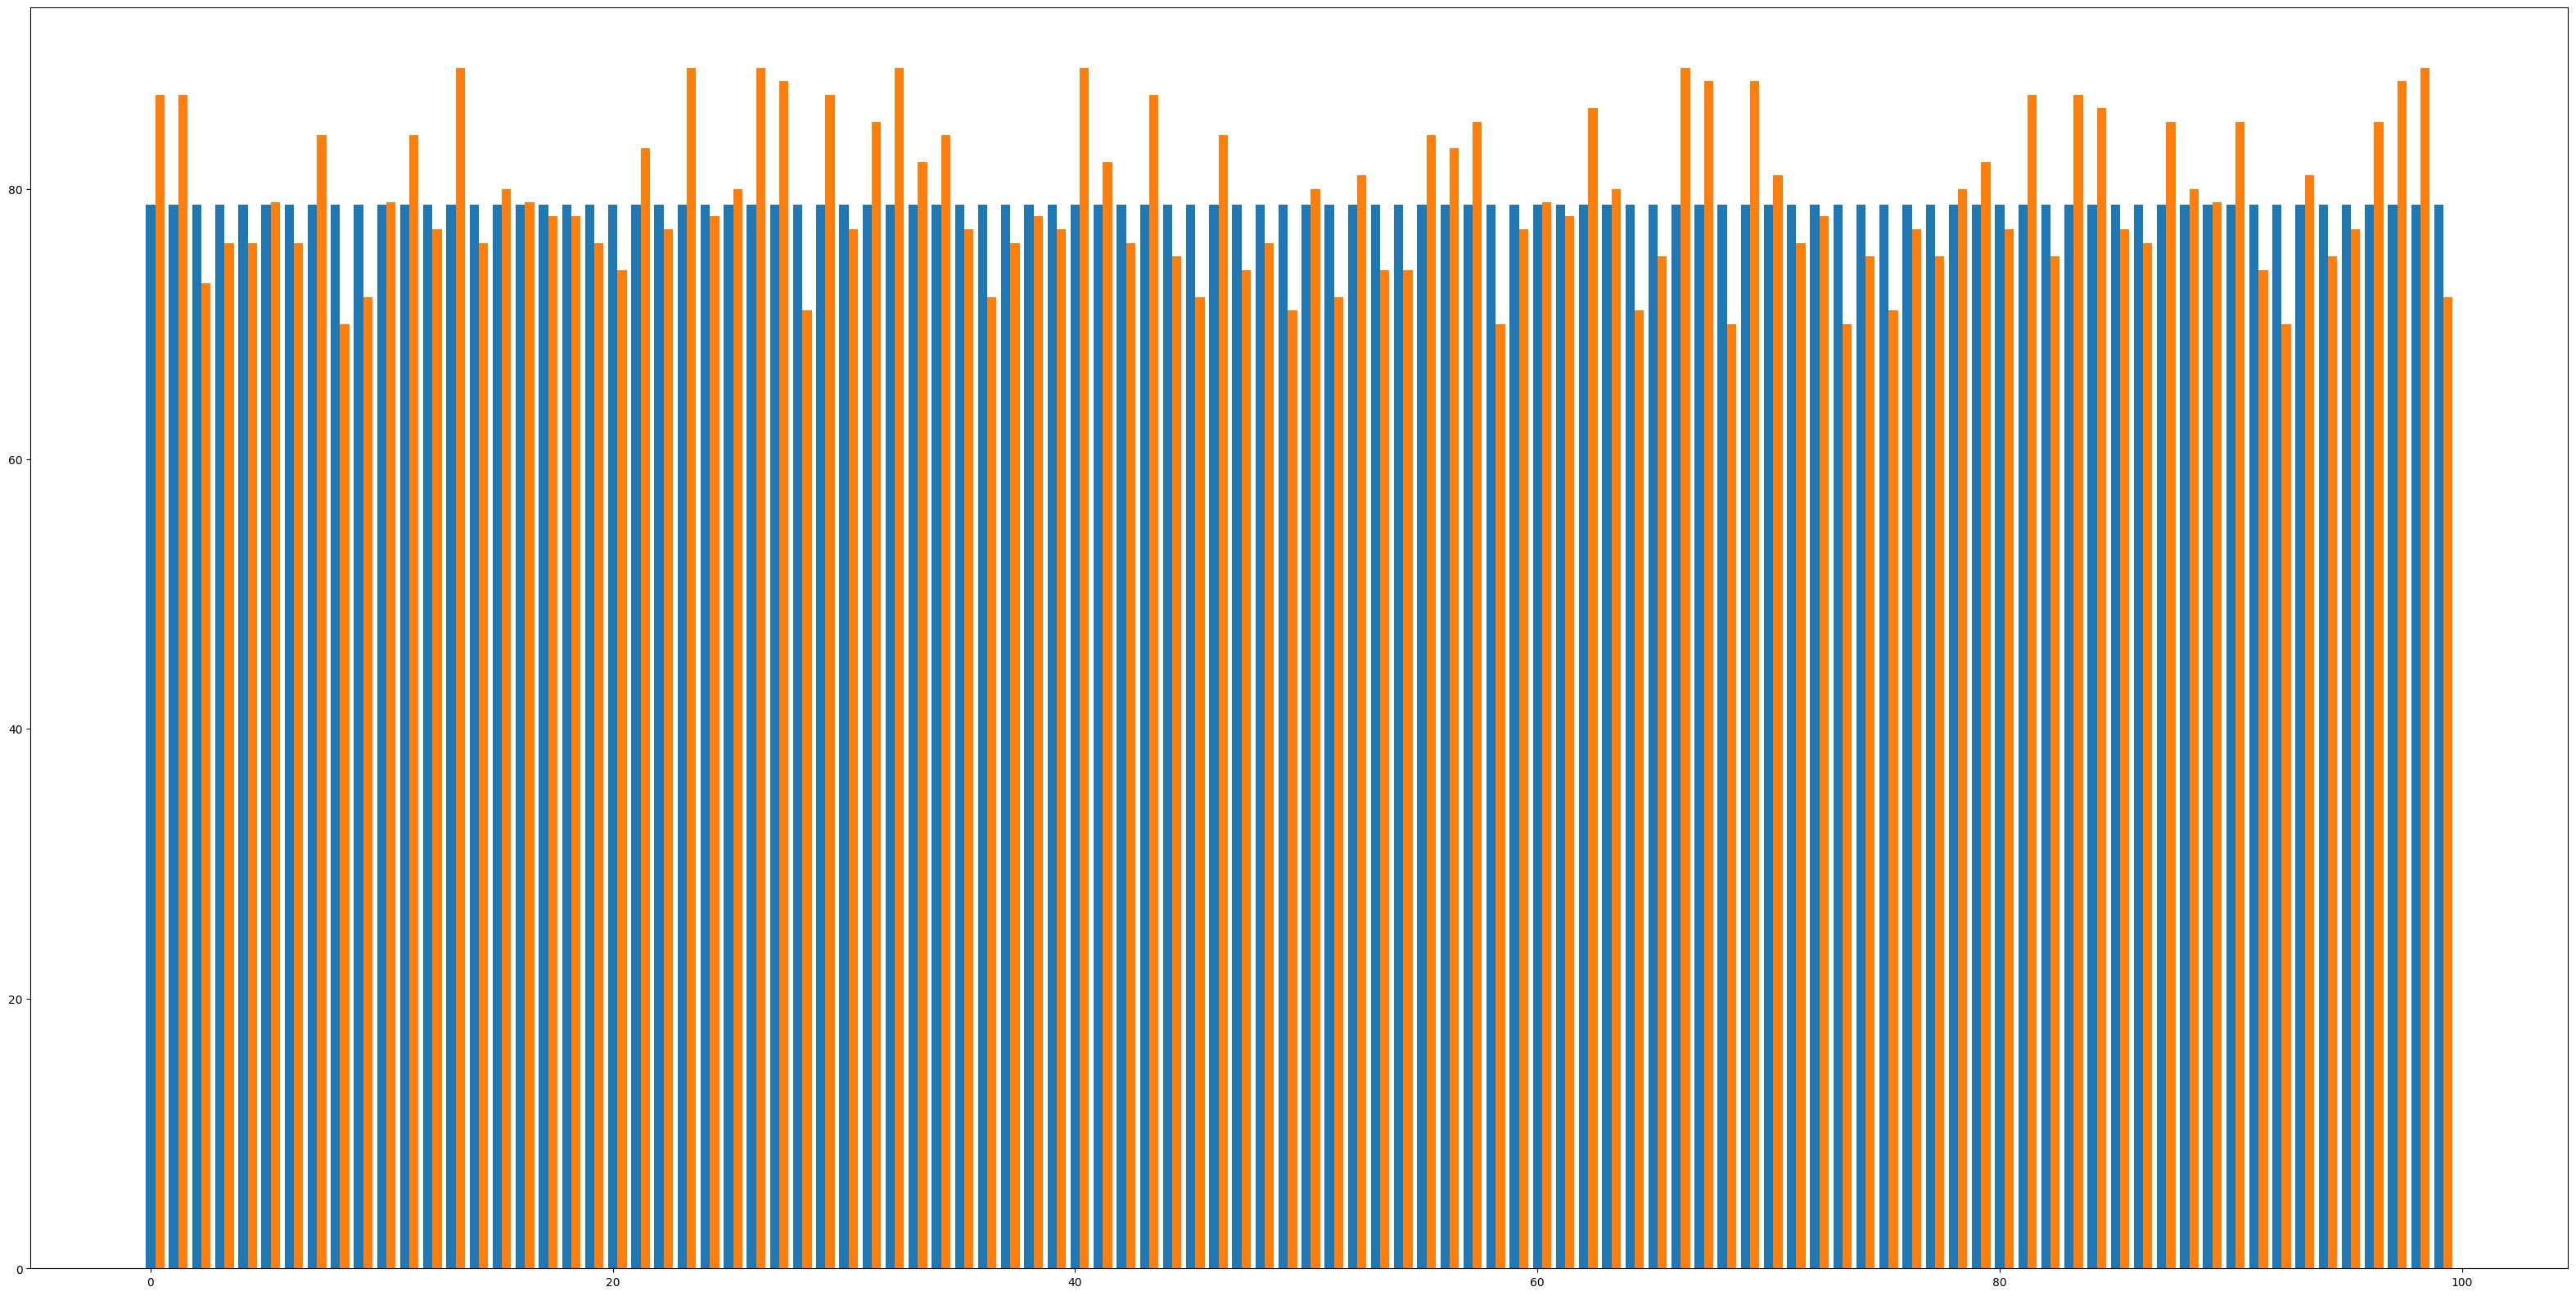

In [ ]:
sbp_pred = model.predict(X_test)[:, 1][500:600]
ind = np.arange(100)
plt.figure(figsize=(40, 20))
width = 0.4
plt.bar(ind, sbp_pred, width)
plt.bar(ind+width, Y_test[:, 1][500:600], width)
plt.show()
model.save("model2.keras")